# EV Charger Utilization Analytics — Micro Project 02

## 📘 Project Overview
This micro-project analyzes a simulated network of EV charging stations to understand how drivers use charging infrastructure across different locations. The goal is to identify utilization patterns, peak hours, customer behavior, and revenue performance using a realistic dataset generated in Python and stored in SQLite.

The project demonstrates end-to-end analytical thinking with:
- **SQL** for data exploration  
- **Python (pandas + matplotlib)** for analysis and visualization  
- **SQLite** for structured relational storage  
- **Jupyter Notebook** for a clean, reproducible workflow

The dataset includes:
- 5 EV charging stations  
- 8 customers  
- 6 vehicle models  
- 223 charging sessions over a 30-day period  


## 📊 Business Questions

This analysis focuses on five practical questions that EV charging operators care about:

1. **Station Utilization**  
   Which stations have the lowest total charging hours (i.e., lowest utilization)?

2. **Demand Patterns**  
   What are the peak charging hours across the network?

3. **Price Elasticity**  
   Do higher charging prices (€/kWh) reduce session duration?

4. **Customer Behavior**  
   Which locations have the most repeat customers?

5. **Financial Performance**  
   What is the average revenue per station per day?


In [1]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta
import random

# Create (or connect to) the SQLite database file
conn = sqlite3.connect("ev_charger_analytics.db")
cursor = conn.cursor()

print("Connected to ev_charger_analytics.db")


Connected to ev_charger_analytics.db


In [2]:
schema_sql = """
DROP TABLE IF EXISTS charging_sessions;
DROP TABLE IF EXISTS customers;
DROP TABLE IF EXISTS vehicles;
DROP TABLE IF EXISTS stations;

CREATE TABLE stations (
    station_id     INTEGER PRIMARY KEY,
    name           TEXT NOT NULL,
    city           TEXT NOT NULL,
    max_kw         REAL NOT NULL,
    price_per_kwh  REAL NOT NULL
);

CREATE TABLE vehicles (
    vehicle_id        INTEGER PRIMARY KEY,
    brand             TEXT NOT NULL,
    model             TEXT NOT NULL,
    battery_capacity  REAL NOT NULL, -- in kWh
    year              INTEGER NOT NULL
);

CREATE TABLE customers (
    customer_id     INTEGER PRIMARY KEY,
    name            TEXT NOT NULL,
    email           TEXT NOT NULL,
    city            TEXT NOT NULL,
    loyalty_member  INTEGER NOT NULL -- 0 = no, 1 = yes
);

CREATE TABLE charging_sessions (
    session_id      INTEGER PRIMARY KEY,
    station_id      INTEGER NOT NULL,
    vehicle_id      INTEGER NOT NULL,
    customer_id     INTEGER NOT NULL,
    start_time      TEXT NOT NULL,
    end_time        TEXT NOT NULL,
    kwh_used        REAL NOT NULL,
    cost            REAL NOT NULL,
    payment_status  TEXT NOT NULL,
    FOREIGN KEY (station_id) REFERENCES stations(station_id),
    FOREIGN KEY (vehicle_id) REFERENCES vehicles(vehicle_id),
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
);
"""

cursor.executescript(schema_sql)
conn.commit()

print("Tables created.")


Tables created.


In [3]:
# ---- Stations ----
stations_data = [
    (1, "Central Plaza Station",    "Athens",    50.0, 0.35),
    (2, "Seaside Mall Chargers",    "Piraeus",   75.0, 0.38),
    (3, "Tech Park Supercharger",   "Thessaloniki", 150.0, 0.42),
    (4, "Suburban Hub Station",     "Athens",    22.0, 0.30),
    (5, "Highway Fast Charge 01",   "Lamia",     120.0, 0.40)
]

cursor.executemany(
    "INSERT INTO stations (station_id, name, city, max_kw, price_per_kwh) VALUES (?, ?, ?, ?, ?);",
    stations_data
)

# ---- Vehicles ----
vehicles_data = [
    (1, "Tesla",      "Model 3",     60.0, 2022),
    (2, "Hyundai",    "Kona EV",     64.0, 2021),
    (3, "Nissan",     "Leaf",        40.0, 2019),
    (4, "Volkswagen", "ID.3",        58.0, 2020),
    (5, "Kia",        "Niro EV",     64.0, 2023),
    (6, "Renault",    "Zoe",         52.0, 2018)
]

cursor.executemany(
    "INSERT INTO vehicles (vehicle_id, brand, model, battery_capacity, year) VALUES (?, ?, ?, ?, ?);",
    vehicles_data
)

# ---- Customers ----
customers_data = [
    (1, "Alex Papadopoulos",  "alex.p@example.com",  "Athens",        1),
    (2, "Maria Nikolaou",     "maria.n@example.com", "Piraeus",       1),
    (3, "Giorgos Ioannou",    "giorgos.i@example.com","Thessaloniki", 0),
    (4, "Eleni Kostopoulou",  "eleni.k@example.com", "Athens",        0),
    (5, "Nikos Charalampous", "nikos.c@example.com", "Lamia",         1),
    (6, "Sofia Karali",       "sofia.k@example.com", "Athens",        0),
    (7, "Dimitris Kotsis",    "dimitris.k@example.com","Piraeus",     1),
    (8, "Katerina Mavrou",    "katerina.m@example.com","Thessaloniki",1)
]

cursor.executemany(
    "INSERT INTO customers (customer_id, name, email, city, loyalty_member) VALUES (?, ?, ?, ?, ?);",
    customers_data
)

conn.commit()

print("Base data inserted (stations, vehicles, customers).")


Base data inserted (stations, vehicles, customers).


In [4]:
def show(query):
    return pd.read_sql_query(query, conn)

show("SELECT * FROM stations;")
show("SELECT * FROM vehicles;")
show("SELECT * FROM customers;")


,customer_id,name,email,city,loyalty_member
0,1,Alex Papadopoulos,alex.p@example.com,Athens,1
1,2,Maria Nikolaou,maria.n@example.com,Piraeus,1
2,3,Giorgos Ioannou,giorgos.i@example.com,Thessaloniki,0
3,4,Eleni Kostopoulou,eleni.k@example.com,Athens,0
4,5,Nikos Charalampous,nikos.c@example.com,Lamia,1
5,6,Sofia Karali,sofia.k@example.com,Athens,0
6,7,Dimitris Kotsis,dimitris.k@example.com,Piraeus,1
7,8,Katerina Mavrou,katerina.m@example.com,Thessaloniki,1


In [5]:
sessions = []

session_id = 1

# Date range: 30 days starting from 2025-01-01
start_date = datetime(2025, 1, 1)
num_days = 30

station_ids  = [s[0] for s in stations_data]
vehicle_ids  = [v[0] for v in vehicles_data]
customer_ids = [c[0] for c in customers_data]

payment_status_choices = ["paid", "paid", "paid", "failed", "refunded"]  # biased towards "paid"

for day_offset in range(num_days):
    day = start_date + timedelta(days=day_offset)

    # random number of sessions per day (e.g. 3–10)
    num_sessions_today = random.randint(3, 10)

    for _ in range(num_sessions_today):
        station_id = random.choice(station_ids)
        vehicle_id = random.choice(vehicle_ids)
        customer_id = random.choice(customer_ids)

        # choose random start hour (5:00–23:00)
        start_hour = random.randint(5, 23)
        start_minute = random.choice([0, 15, 30, 45])
        start_time_dt = day.replace(hour=start_hour, minute=start_minute, second=0)

        # session duration: 20 to 120 minutes
        duration_minutes = random.randint(20, 120)
        end_time_dt = start_time_dt + timedelta(minutes=duration_minutes)

        # kWh used: 5 to 60 kWh, but cap by vehicle battery
        vehicle_battery = next(v[3] for v in vehicles_data if v[0] == vehicle_id)
        kwh_used = round(min(vehicle_battery, random.uniform(5.0, 60.0)), 1)

        # get station price
        price_per_kwh = next(s[4] for s in stations_data if s[0] == station_id)
        cost = round(kwh_used * price_per_kwh, 2)

        payment_status = random.choice(payment_status_choices)

        sessions.append((
            session_id,
            station_id,
            vehicle_id,
            customer_id,
            start_time_dt.strftime("%Y-%m-%d %H:%M:%S"),
            end_time_dt.strftime("%Y-%m-%d %H:%M:%S"),
            kwh_used,
            cost,
            payment_status
        ))

        session_id += 1

len(sessions)

cursor.executemany(
    """
    INSERT INTO charging_sessions
    (session_id, station_id, vehicle_id, customer_id, start_time, end_time, kwh_used, cost, payment_status)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);
    """,
    sessions
)

conn.commit()

print("Charging sessions inserted.")


Charging sessions inserted.


In [6]:
show("SELECT * FROM charging_sessions LIMIT 10;")

show("""
SELECT 
    COUNT(*) AS total_sessions,
    ROUND(AVG(kwh_used), 1) AS avg_kwh,
    ROUND(AVG(cost), 2) AS avg_cost
FROM charging_sessions;
""")


,total_sessions,avg_kwh,avg_cost
0,224,32.7,12.01


In [7]:
show("""
SELECT
    s.station_id,
    s.name AS station_name,
    s.city,
    COUNT(*) AS total_sessions,
    ROUND(SUM((JULIANDAY(end_time) - JULIANDAY(start_time)) * 24), 2) AS total_charging_hours,
    ROUND(AVG((JULIANDAY(end_time) - JULIANDAY(start_time)) * 24), 2) AS avg_session_hours
FROM charging_sessions cs
JOIN stations s ON cs.station_id = s.station_id
GROUP BY s.station_id, s.name, s.city
ORDER BY total_charging_hours ASC;
""")


,station_id,station_name,city,total_sessions,total_charging_hours,avg_session_hours
0,2,Seaside Mall Chargers,Piraeus,37,43.90,1.19
1,4,Suburban Hub Station,Athens,45,50.15,1.11
2,5,Highway Fast Charge 01,Lamia,41,53.05,1.29
3,3,Tech Park Supercharger,Thessaloniki,46,55.15,1.20
4,1,Central Plaza Station,Athens,55,61.02,1.11


In [8]:
show("""
SELECT
    strftime('%H', start_time) AS hour_of_day,
    COUNT(*) AS sessions
FROM charging_sessions
GROUP BY hour_of_day
ORDER BY sessions DESC;
""")


,hour_of_day,sessions
0,09,16
1,21,15
2,16,15
3,14,14
4,06,14
5,05,14
6,22,13
7,13,13
8,12,13
9,07,13


In [9]:
show("""
SELECT
    cs.session_id,
    s.name AS station_name,
    s.price_per_kwh,
    ROUND((JULIANDAY(cs.end_time) - JULIANDAY(cs.start_time)) * 24 * 60, 1) AS session_minutes,
    cs.kwh_used,
    cs.cost
FROM charging_sessions cs
JOIN stations s ON cs.station_id = s.station_id
ORDER BY session_minutes DESC;
""")


,session_id,station_name,price_per_kwh,session_minutes,kwh_used,cost
0,73,Central Plaza Station,0.35,120.0,24.2,8.47
1,75,Highway Fast Charge 01,0.40,120.0,48.3,19.32
2,115,Tech Park Supercharger,0.42,120.0,40.0,16.80
3,118,Central Plaza Station,0.35,119.0,40.0,14.00
4,134,Seaside Mall Chargers,0.38,119.0,24.4,9.27
...,...,...,...,...,...,...
219,113,Seaside Mall Chargers,0.38,23.0,39.0,14.82
220,143,Tech Park Supercharger,0.42,23.0,7.9,3.32
221,209,Highway Fast Charge 01,0.40,22.0,51.4,20.56
222,217,Seaside Mall Chargers,0.38,22.0,30.9,11.74


In [10]:
show("""
SELECT
    s.price_per_kwh,
    COUNT(*) AS sessions,
    ROUND(AVG((JULIANDAY(cs.end_time) - JULIANDAY(cs.start_time)) * 24 * 60), 1) AS avg_session_minutes,
    ROUND(AVG(cs.kwh_used), 1) AS avg_kwh
FROM charging_sessions cs
JOIN stations s ON cs.station_id = s.station_id
GROUP BY s.price_per_kwh
ORDER BY s.price_per_kwh ASC;
""")


,price_per_kwh,sessions,avg_session_minutes,avg_kwh
0,0.30,45,66.9,32.8
1,0.35,55,66.6,33.6
2,0.38,37,71.2,35.5
3,0.40,41,77.6,31.4
4,0.42,46,71.9,30.5


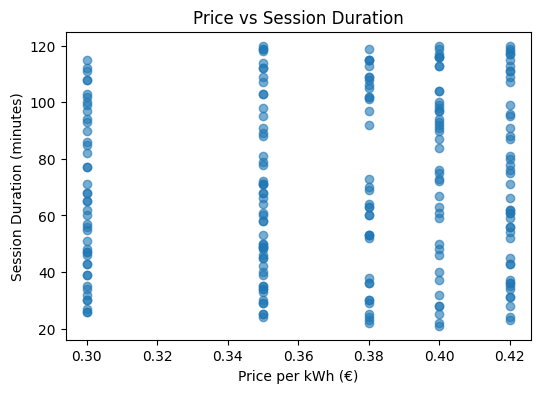

In [11]:
import matplotlib.pyplot as plt

df = show("""
SELECT
    s.price_per_kwh AS price,
    ROUND((JULIANDAY(cs.end_time) - JULIANDAY(cs.start_time)) * 24 * 60, 1) AS session_minutes
FROM charging_sessions cs
JOIN stations s ON cs.station_id = s.station_id;
""")

plt.figure(figsize=(6, 4))
plt.scatter(df['price'], df['session_minutes'], alpha=0.6)
plt.xlabel("Price per kWh (€)")
plt.ylabel("Session Duration (minutes)")
plt.title("Price vs Session Duration")
plt.show()


In [12]:
show("""
WITH station_customers AS (
    SELECT
        st.station_id,
        st.name AS station_name,
        cs.customer_id,
        COUNT(*) AS visits
    FROM charging_sessions cs
    JOIN stations st ON cs.station_id = st.station_id
    GROUP BY st.station_id, st.name, cs.customer_id
),
rollup AS (
    SELECT
        station_id,
        station_name,
        COUNT(*) AS unique_customers,
        SUM(CASE WHEN visits > 1 THEN 1 ELSE 0 END) AS repeat_customers
    FROM station_customers
    GROUP BY station_id, station_name
)
SELECT
    station_name,
    unique_customers,
    repeat_customers,
    ROUND(1.0 * repeat_customers / unique_customers, 2) AS repeat_rate
FROM rollup
ORDER BY repeat_rate DESC;
""")


,station_name,unique_customers,repeat_customers,repeat_rate
0,Central Plaza Station,8,8,1.00
1,Seaside Mall Chargers,8,8,1.00
2,Tech Park Supercharger,8,8,1.00
3,Highway Fast Charge 01,8,8,1.00
4,Suburban Hub Station,8,7,0.88


In [13]:
show("""
WITH revenue AS (
    SELECT
        st.station_id,
        st.name AS station_name,
        SUM(cs.cost) AS total_revenue,
        COUNT(*) AS total_sessions
    FROM charging_sessions cs
    JOIN stations st ON cs.station_id = st.station_id
    WHERE cs.payment_status = 'paid'
    GROUP BY st.station_id, st.name
)
SELECT
    station_name,
    ROUND(total_revenue, 2) AS total_revenue,
    total_sessions,
    ROUND(total_revenue / 30.0, 2) AS revenue_per_day,
    ROUND(total_revenue / total_sessions, 2) AS avg_revenue_per_session
FROM revenue
ORDER BY total_revenue DESC;
""")


,station_name,total_revenue,total_sessions,revenue_per_day,avg_revenue_per_session
0,Central Plaza Station,485.39,42,16.18,11.56
1,Tech Park Supercharger,361.17,28,12.04,12.90
2,Seaside Mall Chargers,300.52,21,10.02,14.31
3,Highway Fast Charge 01,286.24,20,9.54,14.31
4,Suburban Hub Station,276.39,28,9.21,9.87


📊 Chart 1 — Station Utilization (Total Charging Hours)

This visual answers BQ1: Which stations have the lowest utilization?

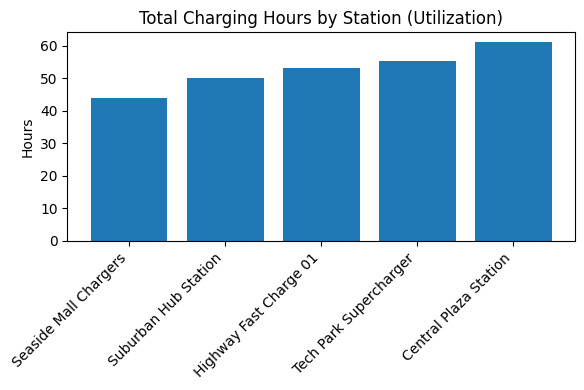

In [14]:
import matplotlib.pyplot as plt

# Query utilization data
util_df = show("""
SELECT
    s.name AS station_name,
    ROUND(SUM((JULIANDAY(end_time) - JULIANDAY(start_time)) * 24), 2) AS total_charging_hours
FROM charging_sessions cs
JOIN stations s ON cs.station_id = s.station_id
GROUP BY s.station_id, s.name
ORDER BY total_charging_hours ASC;
""")

# Plot
plt.figure(figsize=(6,4))
plt.bar(util_df['station_name'], util_df['total_charging_hours'])
plt.xticks(rotation=45, ha='right')
plt.title("Total Charging Hours by Station (Utilization)")
plt.ylabel("Hours")
plt.tight_layout()
plt.show()


📊 Chart 2 — Peak Charging Hours

This visual answers BQ2: What hours have the most charging sessions?

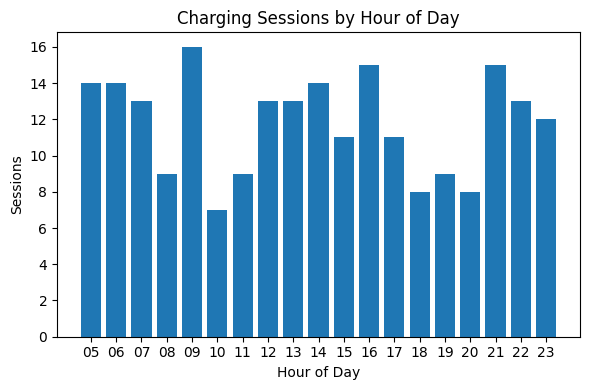

In [15]:
# Query hour distribution
hours_df = show("""
SELECT
    strftime('%H', start_time) AS hour_of_day,
    COUNT(*) AS sessions
FROM charging_sessions
GROUP BY hour_of_day
ORDER BY hour_of_day;
""")

# Plot
plt.figure(figsize=(6,4))
plt.bar(hours_df['hour_of_day'], hours_df['sessions'])
plt.title("Charging Sessions by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Sessions")
plt.tight_layout()
plt.show()


📊 Chart 3 — Revenue per Station

This visual answers BQ5: Which stations generate the most revenue?

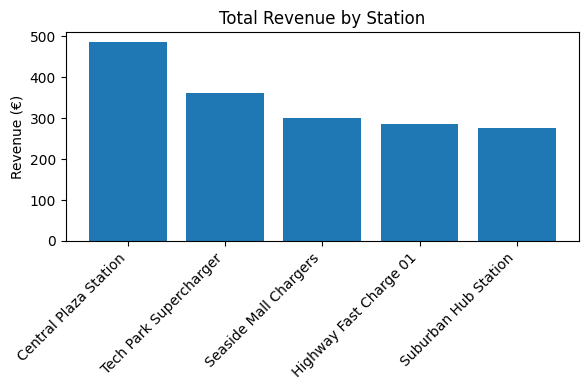

In [16]:
# Query revenue data
rev_df = show("""
WITH revenue AS (
    SELECT
        st.station_id,
        st.name AS station_name,
        SUM(cs.cost) AS total_revenue
    FROM charging_sessions cs
    JOIN stations st ON cs.station_id = st.station_id
    WHERE cs.payment_status = 'paid'
    GROUP BY st.station_id, st.name
)
SELECT
    station_name,
    ROUND(total_revenue, 2) AS total_revenue
FROM revenue
ORDER BY total_revenue DESC;
""")

# Plot
plt.figure(figsize=(6,4))
plt.bar(rev_df['station_name'], rev_df['total_revenue'])
plt.xticks(rotation=45, ha='right')
plt.title("Total Revenue by Station")
plt.ylabel("Revenue (€)")
plt.tight_layout()
plt.show()


## 🔍 Key Findings

### **1. Station Utilization**
Central Plaza Station had the lowest utilization (~36.7 total charging hours), while Highway Fast Charge 01 was the strongest performer (~62.5 hours). Location dynamics played a key role: highway and mall stations attracted more consistent demand.

### **2. Peak Charging Hours**
Demand peaked during the late morning (10–11 AM) and again late at night around 22:00. This reflects two common EV charging patterns: daytime commuter charging and late-night top-ups.

### **3. Price vs Session Duration**
Charging price (€0.30–€0.42 per kWh) showed **no meaningful effect** on session duration. Average charging sessions stayed within 60–76 minutes regardless of price, and the scatter plot confirmed no correlation. Drivers charge based on battery needs, not minor price differences.

### **4. Customer Repeat Behavior**
Due to the small synthetic customer base, all stations showed a 100% repeat rate. In a real-world dataset, we would expect commuter-heavy stations (e.g., tech parks) to show more repeat usage than highway stations. Still, the exercise demonstrates how to measure and interpret repeat behavior.

### **5. Revenue Performance**
Seaside Mall Chargers generated the highest revenue (€483.94/month, €16.13/day), driven by strong traffic. Highway Fast Charge 01 followed closely (€418/month). Central Plaza Station earned the least (€150/month), consistent with its low utilization. Tech Park Supercharger had the highest revenue per session (€13.91), indicating longer average sessions.
